<a href="https://colab.research.google.com/github/kislay960/Data-Science-Practice/blob/main/Pokemon_Classifier_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np
import os

In [2]:
p = Path('/content/drive/My Drive/Images train pokemon')

In [3]:
images = []
dirs = p.glob('*.jpg')
labels_dict = {'Pikachu':0, 'Bulbasaur':1, 'Charmender':2}
for d in dirs:
    img = image.load_img(d,target_size=(40,40))
    img_array = image.img_to_array(img,dtype='uint8')
    img_array = img_array/255.0
    images.append(img_array)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [4]:
len(images)

304

In [5]:
import pandas as pd
train_data = pd.read_csv('https://raw.githubusercontent.com/kislay960/Data-Science-Practice/main/train%20pokemon.csv')

In [6]:
train = train_data.values

In [7]:
labels = train[:,1]

In [8]:
labels[labels=='Bulbasaur'] = 0 
labels[labels=='Pikachu'] = 1
labels[labels=='Charmander'] = 2 

In [9]:
X = np.array(images)
Y = np.array(labels)

from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

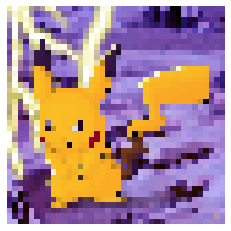

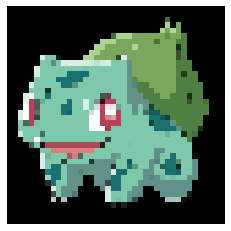

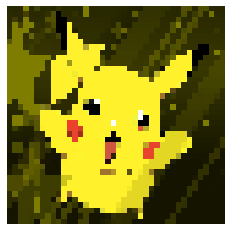

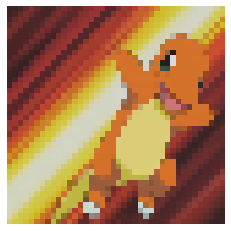

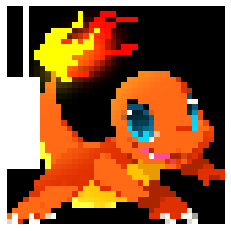

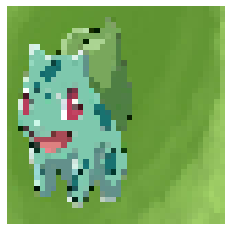

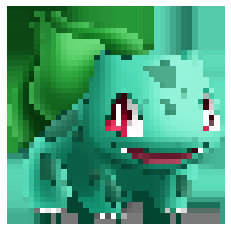

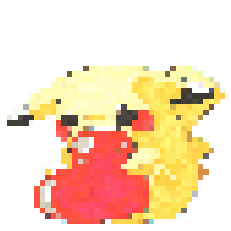

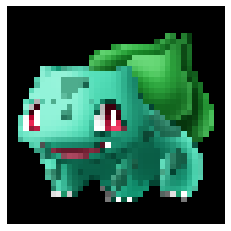

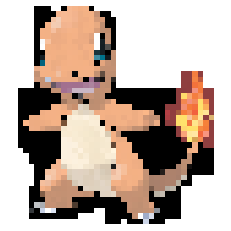

In [10]:
import matplotlib.pyplot as plt

def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

for i in range(50,60):
    drawImg(X[i])

In [12]:
X_ = np.array(X)
Y_ = np.array(Y)

print(X_.shape,Y_.shape)

(304, 40, 40, 3) (304,)


In [11]:
def softmax(a):
    e_pa = np.exp(a)
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans

In [12]:
class NeuralNetwork:

    def __init__(self,input_size,layers,output_size):

        np.random.seed(0)
        model = dict()

        #First Layer
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))

        #Second Layer
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))

        #Third Layer
        model['W3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))

        self.model = model
        self.activation_outputs = None

    def forward(self,x):

        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']

        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1)

        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)

        z3 = np.dot(a2,W3) + b3
        y_ = softmax(z3)

        self.activation_outputs = (a1,a2,y_)
        return y_

    
    def backward(self,x,y,learning_rate=0.01):

        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]

        a1,a2,y_ = self.activation_outputs

        delta3 = y_ - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)

        # we assumed activation function as tanh(z).
        # activation after 2nd layer a2 = tanh(z)
        # derivative of tanh(z) is 1 - tanh^2(z) = 1-a2^2
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)

        #Update the Model Parameters using Gradient Descent
        self.model["W1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["W2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["W3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3

    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)
        
        print("W2 ",W2.shape)
        print("A2 ",a2.shape)
        
        print("W3 ",W3.shape)
        print("Y_ ",y_.shape)

In [13]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

In [14]:
def one_hot(y,depth):
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [15]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

(304, 4800)


In [16]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3)

In [17]:
model.forward(X[0])

array([[0.95821102, 0.0032815 , 0.03850749]])

In [18]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        training_loss.append(l)
        model.backward(X,Y_OHT,learning_rate)
        
        if(logs and ix%10==0):
            print("Epoch %d Loss %.4f"%(ix,l))
            
    return training_loss

In [19]:
model.summary()

W1  (4800, 100)
A1  (1, 100)
W2  (100, 50)
A2  (1, 50)
W3  (50, 3)
Y_  (1, 3)


In [20]:
Y = np.array(Y,dtype=int)

In [21]:
Y.shape

(304,)

In [22]:
l = train(X,Y,model,500,0.0002)

Epoch 0 Loss 2.6684
Epoch 10 Loss 0.9570
Epoch 20 Loss 0.5111
Epoch 30 Loss 0.3750
Epoch 40 Loss 0.2807
Epoch 50 Loss 0.2140
Epoch 60 Loss 0.1839
Epoch 70 Loss 0.1637
Epoch 80 Loss 0.1442
Epoch 90 Loss 0.1289
Epoch 100 Loss 0.1149
Epoch 110 Loss 0.1033
Epoch 120 Loss 0.0911
Epoch 130 Loss 0.0842
Epoch 140 Loss 0.0788
Epoch 150 Loss 0.0741
Epoch 160 Loss 0.0700
Epoch 170 Loss 0.0665
Epoch 180 Loss 0.0634
Epoch 190 Loss 0.0605
Epoch 200 Loss 0.0577
Epoch 210 Loss 0.0545
Epoch 220 Loss 0.0535
Epoch 230 Loss 0.0514
Epoch 240 Loss 0.0494
Epoch 250 Loss 0.0477
Epoch 260 Loss 0.0461
Epoch 270 Loss 0.0445
Epoch 280 Loss 0.0431
Epoch 290 Loss 0.0418
Epoch 300 Loss 0.0406
Epoch 310 Loss 0.0394
Epoch 320 Loss 0.0384
Epoch 330 Loss 0.0373
Epoch 340 Loss 0.0364
Epoch 350 Loss 0.0355
Epoch 360 Loss 0.0347
Epoch 370 Loss 0.0339
Epoch 380 Loss 0.0332
Epoch 390 Loss 0.0325
Epoch 400 Loss 0.0318
Epoch 410 Loss 0.0312
Epoch 420 Loss 0.0306
Epoch 430 Loss 0.0300
Epoch 440 Loss 0.0295
Epoch 450 Loss 0.0289

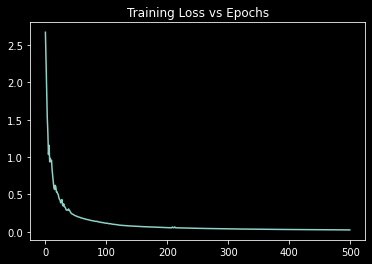

In [23]:
from matplotlib import pyplot as plt
plt.style.use("dark_background")
plt.title("Training Loss vs Epochs")
plt.plot(l)
plt.show()

In [25]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Acc %.4f"%getAccuracy(X,Y,model))

Train Acc 0.9836


In [26]:
p = Path('/content/drive/My Drive/Images test pokemon')

In [27]:
images_test = []
poke_id = []
dirs = p.glob('*.jpg')
labels_dict = {'Pikachu':0, 'Bulbasaur':1, 'Charmender':2}
for d in dirs:
    poke_id.append(str(d).split('/')[-1])
    img = image.load_img(d,target_size=(40,40))
    img_array = image.img_to_array(img,dtype='uint8')
    img_array = img_array/255.0
    images_test.append(img_array)

In [28]:
len(images_test)

123

In [29]:
XTest = np.array(images_test)

In [30]:
XTest = XTest.reshape(XTest.shape[0],-1)

In [31]:
test_data = pd.read_csv('https://raw.githubusercontent.com/kislay960/Data-Science-Practice/main/test%20pokemon.csv')

In [32]:
test = test_data.values

In [33]:
ans = []

In [34]:
XTest.shape

(123, 4800)

In [35]:
for i in range(123):
    index = poke_id.index(test[i][0])
    ans.append(model.predict(XTest[index]))

In [36]:
ans = np.array(ans)

In [38]:
ans = ans.reshape(123,)

In [39]:
ans

array([0, 2, 0, 2, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 2,
       2, 0, 2, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2,
       2, 0, 0, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0,
       1, 2, 2, 2, 2, 1, 2, 0, 0, 1, 2, 0, 1])

In [40]:
rev_dict = {1:"Pikachu",2:"Charmander",0:"Bulbasaur"}
lst = [rev_dict[num] for num in ans]

In [41]:
test_data['NameOfPokemon'] = lst

In [42]:
test_data.head()

,ImageId,NameOfPokemon
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Charmander
4,2011.jpg,Charmander


In [43]:
test_data.to_csv('submission.csv',index=False)

**On submission, we found the test accuracy to be 78%**